In [1]:
import time

import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear

from panther.nn import SKLinear

In [2]:
# Load the dataset
data = pd.read_csv("../datasets/diabetes[1].csv")
X = torch.tensor(data.iloc[:, :-1].values, dtype=torch.float32)
# Add quadratic features
X_quad = torch.cat([X for i in range(1, 2)], dim=1)
y = torch.tensor(data.iloc[:, -1].values, dtype=torch.float32).view(-1, 1)

In [ ]:
# Define the training function
def train_model(model, criterion, optimizer, X, y, epochs=200, batch_size=32):
    model.train()
    losses = []
    for _ in range(epochs):
        print("Epoch", _)
        for i in range(0, len(X), batch_size):
            print("Batch", i // batch_size)
            X_batch = X[i : i + batch_size]
            y_batch = y[i : i + batch_size]
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
    return losses


# Define the timing function
def time_model(model, X, y, criterion):
    model.eval()
    with torch.no_grad():
        # Time inference
        torch.cuda.synchronize()
        start_time = time.perf_counter()
        outputs = model(X)
        inference_time = time.perf_counter() - start_time

    # Time backpropagation
    model.train()
    outputs = model(X)
    loss = criterion(outputs, y)
    torch.cuda.synchronize()
    start_time = time.perf_counter()
    loss.backward()
    backprop_time = time.perf_counter() - start_time

    return inference_time, backprop_time

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LinearModel, self).__init__()
        self.layer1 = Linear(in_features=input_dim, out_features=hidden_dim)
        self.relu = nn.ReLU()
        self.layer2 = Linear(in_features=hidden_dim, out_features=output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.sigmoid(x)
        return x


class SKLinearModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SKLinearModel, self).__init__()
        self.layer1 = SKLinear(
            in_features=input_dim,
            out_features=hidden_dim,
            num_terms=3,
            low_rank=8,
        )
        self.relu = nn.ReLU()
        self.layer2 = Linear(
            in_features=hidden_dim,
            out_features=output_dim,
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.sigmoid(x)
        return x

: 

In [ ]:
# Initialize models, criterion, and optimizers
input_dim = X_quad.shape[1]
hidden_dim = 100
output_dim = 1

linear_model = LinearModel(
    input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim
).cuda()
sklinear_model = SKLinearModel(
    input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim
).cuda()

criterion = nn.BCELoss()
linear_optimizer = optim.Adam(linear_model.parameters(), lr=0.01)
sklinear_optimizer = optim.Adam(sklinear_model.parameters(), lr=0.01)

# Replace inf values with a large finite number
X_quad = torch.nan_to_num(X_quad, nan=0.0, posinf=1e6, neginf=-1e6)

# Train both models
linear_losses = train_model(
    linear_model,
    criterion,
    linear_optimizer,
    X_quad.cuda(),
    y.cuda(),
    100,
    X_quad.shape[0],
)
sklinear_losses = train_model(
    sklinear_model,
    criterion,
    sklinear_optimizer,
    X_quad.cuda(),
    y.cuda(),
    100,
    X_quad.shape[0],
)

In [ ]:
# Time both models
linear_inference_time, linear_backprop_time = time_model(
    linear_model, X_quad.cuda(), y.cuda(), criterion
)
sklinear_inference_time, sklinear_backprop_time = time_model(
    sklinear_model, X_quad.cuda(), y.cuda(), criterion
)

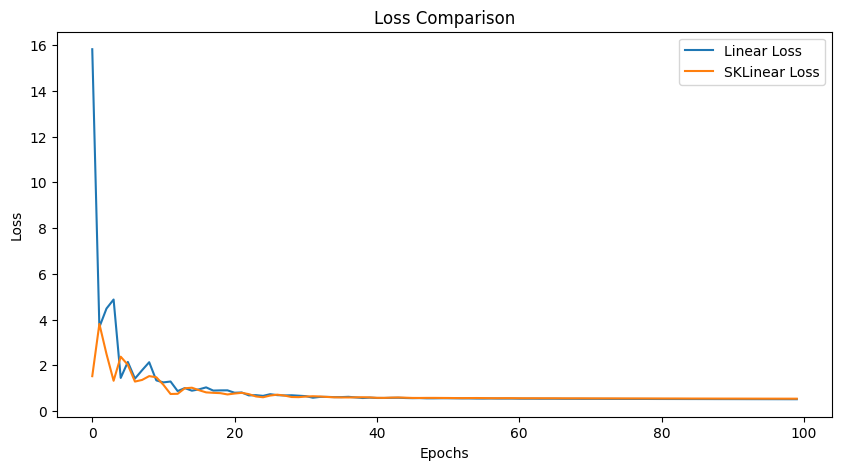

In [ ]:
# Plot the loss graph
plt.figure(figsize=(10, 5))
plt.plot(linear_losses, label="Linear Loss")
plt.plot(sklinear_losses, label="SKLinear Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Comparison")
plt.legend()
plt.show()

0.00041899999996530823 0.0010293000013916753


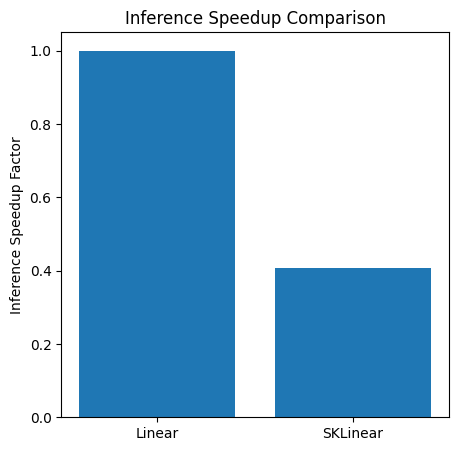

In [ ]:
# Plot the speedup graph for inference
inference_speedup = linear_inference_time / sklinear_inference_time
print(linear_inference_time, sklinear_inference_time)
plt.figure(figsize=(5, 5))
plt.bar(["Linear", "SKLinear"], [1, inference_speedup])
plt.ylabel("Inference Speedup Factor")
plt.title("Inference Speedup Comparison")
plt.show()

0.0011615999992500292 0.002094700001180172


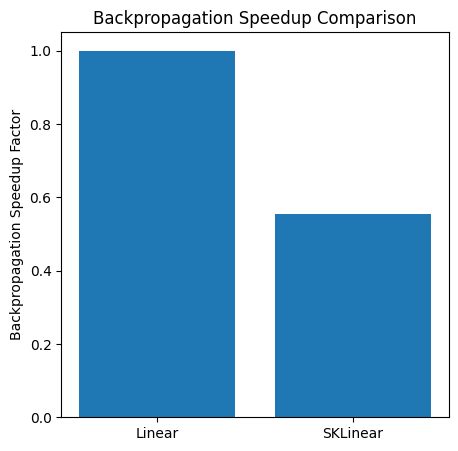

In [ ]:
# Plot the speedup graph for backpropagation
backprop_speedup = linear_backprop_time / sklinear_backprop_time
print(linear_backprop_time, sklinear_backprop_time)
plt.figure(figsize=(5, 5))
plt.bar(["Linear", "SKLinear"], [1, backprop_speedup])
plt.ylabel("Backpropagation Speedup Factor")
plt.title("Backpropagation Speedup Comparison")
plt.show()

In [ ]:
model = SKLinearModel(input_dim=3, hidden_dim=hidden_dim, output_dim=output_dim).cuda()
input_tensor = torch.randn(3, 3, dtype=torch.float64, requires_grad=True, device="cuda")

# Apply gradcheck
is_correct = torch.autograd.gradcheck(model, (input_tensor,))
print(is_correct)

RuntimeError: expected scalar type Float but found Double